# Settings and data loading
---
This cell is to be run prior to all others. It sets parameters for data loading, plotting and saving.
All other cells are structured to be authonomously run.

In [3]:
import os
import numpy as np 
import matplotlib.pyplot as  plt 
from matplotlib import colormaps 
from matplotlib import colors
from scipy.optimize import curve_fit,fsolve  
import importlib

import ExperimParams as e
importlib.reload(e)

#--------------------------------------------------------
def readTable1(dirIn="SPARCdata"):
    """
    Read data in "table1.dat" file in the dirIn folder, returns a list of dictionaries (named table).
    Each dict item is a row of the table, as in the description below. Dict keys correspond to labels in the table.

    ================================================================================
    Byte-by-byte Description of file: Table1.mrt
    --------------------------------------------------------------------------------
    Bytes Format Units         Label   Explanations
    --------------------------------------------------------------------------------
    1- 11 A11    ---           Galaxy  Galaxy Name
    12- 13 I2     ---           T       Hubble Type (1)
    14- 19 F6.2   Mpc           D       Distance
    20- 24 F5.2   Mpc         e_D       Mean error on D
    25- 26 I2     ---         f_D       Distance Method (2)
    27- 30 F4.1   deg           Inc     Inclination
    31- 34 F4.1   deg         e_Inc     Mean error on Inc
    35- 41 F7.3   10+9solLum    L[3.6]  Total Luminosity at [3.6]
    42- 48 F7.3   10+9solLum  e_L[3.6]  Mean error on L[3.6]
    49- 53 F5.2   kpc           Reff    Effective Radius at [3.6]
    54- 61 F8.2   solLum/pc2    SBeff   Effective Surface Brightness at [3.6]
    62- 66 F5.2   kpc           Rdisk   Disk Scale Length at [3.6]
    67- 74 F8.2   solLum/pc2    SBdisk  Disk Central Surface Brightness at [3.6]
    75- 81 F7.3   10+9solMass   MHI     Total HI mass
    82- 86 F5.2   kpc           RHI     HI radius at 1 Msun/pc2
    87- 91 F5.1   km/s          Vflat   Asymptotically Flat Rotation Velocity
    92- 96 F5.1   km/s        e_Vflat   Mean error on Vflat
    97- 99 I3     ---           Q       Quality Flag (3)
    100-113 A14    ---           Ref.    References for HI and Ha data (4)
    --------------------------------------------------------------------------------
    """
    filepath = os.path.join(dirIn, "Table1.dat")
    fileVar = open(filepath, 'r')
    counter = 0
    table = []
    for line in fileVar:
        if counter < 98 or line=="":
            pass
        else: 
            values = np.fromstring(line[11:-14], dtype=float, sep=' ')
            dictItem = {"name":     line[:11].lstrip(), 
                        "T":        int(  values[0]),
                        "D":        float(values[1]),
                        "e_D":      float(values[2]),
                        "f_D":      int(  values[3]),
                        "Inc":      float(values[4]),
                        "e_Inc":    float(values[5]),
                        "L[3.6]":   float(values[6]),
                        "e_L[3.6]": float(values[7]),
                        "Reff":     float(values[8]),
                        "SBeff":    float(values[9]),
                        "Rdisk":    float(values[10]),
                        "SBdisk":   float(values[11]),
                        "MHI":      float(values[12]),
                        "RHI":      float(values[13]),
                        "Vflat":    float(values[14]),
                        "e_Vflat":  float(values[15]),
                        "Q":        int(  values[16]),
                        "Ref":      line[-14:].lstrip()}
            table.append(dictItem)
        counter = counter +1
    return np.array(table)
#---------------------------------------------------------
def readRotmod(dirIn="SPARCdata/Rotmod_LTG"):
    """
    Inport data from "Rotmod_LTG" files. Files structure:
    Cols: Rad(kpc)	Vobs(km/s)	errV(km/s)	Vgas(km/s)	Vdisk(km/s)	Vbul(km/s)	SBdisk(L/pc^2)	SBbul(L/pc^2)	
    Output: list of data, each data is numpy array with cols as in files.
    """
    #input settings
    file_list= os.listdir(dirIn)

    #loading experimental data
    data_list  = [] #each entry is one file of data
    names_list = [] #save names of datasets, in same order as in data_list
    for file in file_list:
        filepath = os.path.join(dirIn, file)
        dataset = np.loadtxt(filepath, dtype=float)
        data_list.append(dataset)
        names_list.append(file[:-11])
    
    #return data 
    return data_list, names_list

#--- Data Loading -------------------------------------------
#load Table 1
table = readTable1()
#load data from Rotmod
data_list, names_list = readRotmod()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13608\1172968308.py:52: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  values = np.fromstring(line[11:-14], dtype=float, sep=' ')


# Computing Densities
---

This cell computes an effective radially symmetric volumetric density profile for Disk, Bulge and Gas, based on rotation curves, $\rho(r) = \frac{1}{r^2}\frac{d}{dr}\frac{v^2(r) r}{4\pi G}$. <br>
Then it fits the effective density datapoints with an exponential profile, $\rho(r) = a e^{-r/r_0}$. 

Resulting fit parameters (amplitudes $a$, characteristic radii $r_0$) for every galaxy are saved to `.dat` file. <br>
The following computed profiles are plotted and saved in subfolders:
- effective volumetric density $\rho(r)$ in logscale;
- effective surface brightness $\Sigma(r) = r\rho(r)$;
- effective velocities $v(r)= \sqrt{\frac{4\pi G \int_0^r \rho(s) s^2 ds}{r}}$

In [4]:
#output setting - fit parameters
dirOutParams = "Results"
nameParams = "densityParams.dat"
#output setting - plots
dirOutPath = "SPARCplots/"
dirOut = "Computed_EffectiveDensities"
dirOutFit = "/LogRho"
dirOutVel = "/EffVel"
dirOutSurfBright = "/EffSurfBright"

#--------------------------------------------------------------------
#create output subfolders, if needed
os.makedirs(dirOutParams, exist_ok=True)
os.makedirs(dirOutPath+dirOut+dirOutFit, exist_ok=True)
os.makedirs(dirOutPath+dirOut+dirOutVel, exist_ok=True)
os.makedirs(dirOutPath+dirOut+dirOutSurfBright, exist_ok=True)

#derivative function
def deriv(f,r):
	dfdr = np.zeros_like(f)
	dfdr[0] = (f[1]-f[0])/(r[1]-r[0])
	dfdr[1:-1] = (f[2:]-f[:-2])/(r[2:]-r[:-2])
	dfdr[-1] = (f[-1]-f[-2])/(r[-1]-r[-2])
	return dfdr

#initialize for data saving
densParam = np.zeros((len(data_list), 6))

#loop through data
for i in range(len(data_list)):     
    #get data
    data = data_list[i]
    tableRow = table[i]

    #--- Computing Density profiles and fitting parameters ---------------------------
    # DISK:
    rD = data[:,0]
    vD = data[:,4]
    #compute effective density rho(r) from velocity v(r):  rho(r) = d_r(V^2 *R) /4piG
    rhoEffD = (vD**2/rD**2+2*vD*deriv(vD,rD)/rD)/(4*np.pi*e.Gastro)
    #select data (neglect final points with zero effective density)
    endIdx=None
    if (rhoEffD<=0).any():
        endIdx = np.min(np.where(rhoEffD<=0))
    rD = rD[:endIdx]
    vD = vD[:endIdx]
    rhoEffD = rhoEffD[:endIdx]
    #fit luminosity: rho(r) = a e^(-r/r0)
    mD,qD = np.polyfit(rD,np.log(rhoEffD),1)
    # get exponential law parameters a,r0 
    r0D = -1.0/mD
    aD  = np.exp(qD)   
    # OPTIONAL: compute effective surf densities
    sEffD = rhoEffD*rD
    # OPTIONAL: compute back velocities from rho(r)
    vEffD = np.sqrt( 4*np.pi*e.Gastro*aD /rD *( 2*r0D**3 - r0D*np.exp(-rD/r0D)*(rD**2 +2*rD*r0D +2*r0D**2)) )
    
    #BULGE
    #Performed only if Bulge is present
    isBul = False
    if (data[:,7]<0.01).all():
        # Bulge not present
        r0B = 0.0
        aB  = 0.0
    else:
        # Bulge present
        isBul = True
        rB = data[:,0]
        vB = data[:,5]
        #compute effective density rho(r) from velocity v(r):  rho(r) = d_r(V^2 *R) /4piG
        rhoEffB = (vB**2/rB**2+2*vB*deriv(vB,rB)/rB)/(4*np.pi*e.Gastro)
        #select data (neglect final points with zero effective density)
        endIdx=None
        if (rhoEffB<=0).any():
            endIdx = np.min(np.where(rhoEffB<=0))
        rB = rB[:endIdx]
        vB = vB[:endIdx]
        rhoEffB = rhoEffB[:endIdx]
        #fit luminosity: rho(r) = a e^(-r/r0)
        mB,qB = np.polyfit(rB,np.log(rhoEffB),1)
        # get exponential law parameters a,r0 
        r0B = -1.0/mB
        aB  = np.exp(qB)   
        # OPTIONAL: compute effective surf densities
        sEffB = rhoEffB*rB
        # OPTIONAL: compute back velocities from rho(r)
        vEffB = np.sqrt( 4*np.pi*e.Gastro*aB /rB *( 2*r0B**3 - r0B*np.exp(-rB/r0B)*(rB**2 +2*rB*r0B +2*r0B**2)) )

    #GAS 
    rG = data[:,0]
    vG = data[:,3]
    #select data (neglect initial points with negative vel)
    startIdx=None
    if (vG<0).any():
        startIdx = np.max(np.where(vG<0))+1  
    rG = rG[startIdx:]
    vG = vG[startIdx:]
    #compute effective density rho(r) from velocity v(r):  rho(r) = d_r(V^2 *R) /4piG
    rhoEffG = (vG**2/rG**2+2*vG*deriv(vG,rG)/rG)/(4*np.pi*e.Gastro)
    #select data (neglect final points with zero effective density)
    selectIdx=np.full(len(rhoEffG), True)
    for j in range(len(rhoEffG)):
        if rhoEffG[j]<=0:
            selectIdx[j]=False
    rG = rG[selectIdx]
    vG = vG[selectIdx]
    rhoEffG = rhoEffG[selectIdx]
    #fit luminosity: rho(r) = a e^(-r/r0)
    mG,qG = np.polyfit(rG,np.log(rhoEffG),1)
    # get exponential law parameters a,r0 
    r0G = -1.0/mG
    aG  = np.exp(qG)   
    # OPTIONAL: compute effective surf densities
    sEffG = rhoEffG*rG
    # OPTIONAL: compute back velocities from rho(r)
    vEffG = np.sqrt( 4*np.pi*e.Gastro*aG /rG *( 2*r0G**3 - r0G*np.exp(-rG/r0G)*(rG**2 +2*rG*r0G +2*r0G**2)) )

    #--- Plot Computed Profiles ----------------------------------------------------------
    #Plot logRho
    plt.figure()
    plt.yscale('log')
    # - Disk
    plt.plot(rD,rhoEffD,color="tab:orange",marker='o',linestyle="",label=r"effective data $\rho_{{Disk}}(r)$")
    plt.plot(rD,aD* np.exp(-rD/r0D),color="tab:orange",linestyle="dotted",label=f"fit: {aD:.2f} exp(-r/{r0D:.2f})")
    # - Bulge
    if  isBul:
        plt.plot(rB,rhoEffB,color="tab:green",marker='o',linestyle="",label=r"effective data $\rho_{{Bulge}}(r)$")
        plt.plot(rB, aB*np.exp(-rB/r0B),color="tab:green",linestyle="dotted",label=f"fit: {aB:.2f} exp(-r/{r0B:.2f})")
    # - Gas
    plt.plot(rG,rhoEffG,color="tab:blue",marker='o',linestyle="",label=r"effective data $\rho_{{Gas}}(r)$")
    plt.plot(rG,aG*np.exp(-rG/r0G),color="tab:blue",linestyle="dotted",label=f"fit: {aG:.2f} exp(-r/{r0G:.2f})")
    #
    plt.title(names_list[i])
    plt.legend()
    plt.xlabel("R (kpc)")
    plt.ylabel(r"$\rho$ ($L_\odot / pc^2 kpc$)")
    #save and close
    figname = names_list[i]+"_logRho"
    figpath = os.path.join(dirOutPath+dirOut+dirOutFit,figname)
    plt.savefig(figpath,dpi=300)
    plt.close()

    #OPTIONAL: plot velocities
    plt.figure()
    # - Disk
    plt.plot(data[:,0],data[:,4],color="tab:orange",marker='o',linestyle="",label=f"$V^{{Exp}}_{{Disk}}$")
    plt.plot(rD,vEffD,color="tab:orange",marker='+',linestyle="dashed",label=f"$V^{{Eff}}_{{Disk}}$")
    # - Bulge
    if  isBul:
        plt.plot(data[:,0],data[:,5],color="tab:green",marker='o',linestyle="",label=f"$V^{{Exp}}_{{Bulge}}$")
        plt.plot(rB,vEffB,color="tab:green",marker='+',linestyle="dashed",label=f"$V^{{Eff}}_{{Bulge}}$")
    # - Gas
    plt.plot(data[:,0],data[:,3],color="tab:blue",marker='o',linestyle="",label=f"$V^{{Exp}}_{{Gas}}$")
    plt.plot(rG,vEffG,color="tab:blue",marker='+',linestyle="dashed",label=f"$V^{{Eff}}_{{Gas}}$")
    #
    plt.xlabel("R (kpc)")
    plt.ylabel("V (km/s)")
    plt.title(names_list[i])
    plt.legend()
    #save and close
    figname = names_list[i]+"_effVel"
    figpath = os.path.join(dirOutPath+dirOut+dirOutVel,figname)
    plt.savefig(figpath,dpi=300)
    plt.close()

    #OPTIONAL: plot surface densities
    plt.figure()
    # - Disk
    plt.plot(data[:,0],data[:,6],color="tab:orange",marker='o',linestyle="",label=f"$\Sigma^{{Exp}}_{{Disk}}$")
    plt.plot(rD,sEffD,color="tab:orange",marker='+',linestyle="dashed",label=f"$\Sigma^{{Eff}}_{{Disk}}$")
    # - Bulge
    if  isBul:
        plt.plot(data[:,0],data[:,7],color="tab:green",marker='o',linestyle="",label=f"$\Sigma^{{Exp}}_{{Bulge}}$")
        plt.plot(rB,sEffB,color="tab:green",marker='+',linestyle="dashed",label=f"$\Sigma^{{Eff}}_{{Bulge}}$")
    # - Gas
    plt.plot(rG,sEffG,color="tab:blue",marker='+',linestyle="dashed",label=f"$\Sigma^{{Eff}}_{{Gas}}$")
    #
    plt.xlabel("R (kpc)")
    plt.ylabel(f"$\Sigma$ (L$_\odot$/pc$^2$)")
    plt.title(names_list[i])
    plt.legend()
    #save and close
    figname = names_list[i]+"_effSurfBright"
    figpath = os.path.join(dirOutPath+dirOut+dirOutSurfBright,figname)
    plt.savefig(figpath,dpi=300)
    plt.close()

    #save parameters 
    densParam[i,:]=np.array([r0D, aD, r0B, aB, r0G, aG])

#OPTIONAL: print parameters to file
np.savetxt(dirOutParams+"/"+nameParams,densParam,header="\tr0D\t\t\taD\t\t\tr0B\t\t\taB\t\t\tr0G\t\t\taG")
    

c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Lenovo\anaconda3\envs\phd\Lib\site-p

# Check for relations between fit parameters
---
Run this cell to load data for the analysis. Then, the following cells can be run.

In [5]:
from scipy import stats

#input parameters for density results analysis 
dirIn = "Results"
nameIn = "densityParams.dat"

# loading parameters
filepath = os.path.join(dirIn, nameIn)
densParam = np.loadtxt(filepath, dtype=float)

## 1. Check on Amplitudes
*Test:* Visually compare (via scattered plots) the amplitudes $a_D$,$a_B$, $a_G$ across different galaxies, to see if they are in any relation. Galaxies are colored by Hubble type (see `table1.dat`). Spearman correlation Test is performed. <br>
*Result:* Amplitudes for Disk, Bulge and Gas are not strongly related.

aD-aB. Spearman coeff (0 for uncorr, +-1 for corr): 0.2625,	pvalue: 0.0004
aD-aG. Spearman coeff (0 for uncorr, +-1 for corr): 0.0766,	pvalue: 0.3139
aB-aG. Spearman coeff (0 for uncorr, +-1 for corr): -0.2167,	pvalue: 0.0040


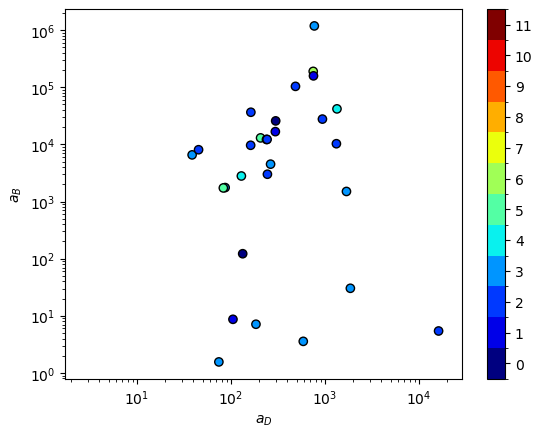

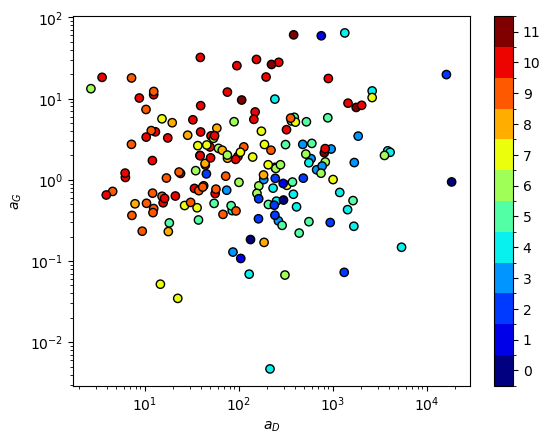

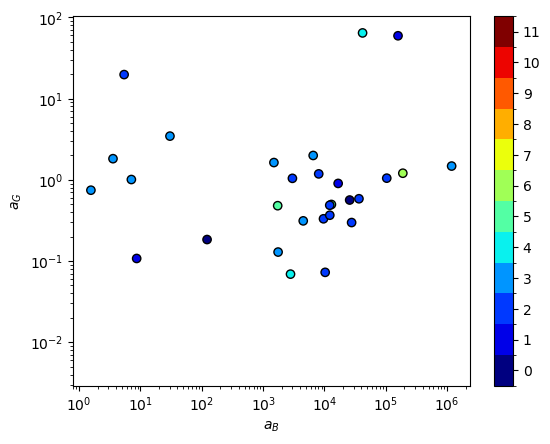

In [8]:
# figure settings for colormap
cmap = plt.cm.jet
norm = colors.BoundaryNorm(np.arange(-0.5, 12, 1), cmap.N)
# extract Hubble types
hType_list = [t["T"] for t in table]

# Compare Disk and Bulge (if present), scattered plot
plt.figure()
plt.scatter(densParam[:,1],densParam[:,3],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$a_D$")
plt.ylabel(f"$a_B$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,1],densParam[:,3])
print(f"aD-aB. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.4f}")

# Compare Disk and Gas, scattered plot
plt.figure()
plt.scatter(densParam[:,1],densParam[:,5],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$a_D$")
plt.ylabel(f"$a_G$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,1],densParam[:,5])
print(f"aD-aG. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.4f}")

# Compare Bulge (if present) and Gas, scattered plot
plt.figure()
plt.scatter(densParam[:,3],densParam[:,5],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$a_B$")
plt.ylabel(f"$a_G$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,3],densParam[:,5])
print(f"aB-aG. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.4f}")




## 2. Check on Characteristic Radii
*Test:* Visually compare (via scattered plots) the characteristic radii $r_{0,D}$,$r_{0,B}$, $r_{0,G}$ across different galaxies, to see if they are in any relation. Galaxies are colored by Hubble type (see `table1.dat`) Spearman correlation Test is performed. <br>
*Result:* Characteristic radii for Disk, Bulge and Gas are not strongly related.

rD-rB. Spearman coeff (0 for uncorr, +-1 for corr): 0.2683,	pvalue: 0.0003
rD-rG. Spearman coeff (0 for uncorr, +-1 for corr): 0.4228,	pvalue: 5.58e-09
rB-rG. Spearman coeff (0 for uncorr, +-1 for corr): 0.1033,	pvalue: 0.1735


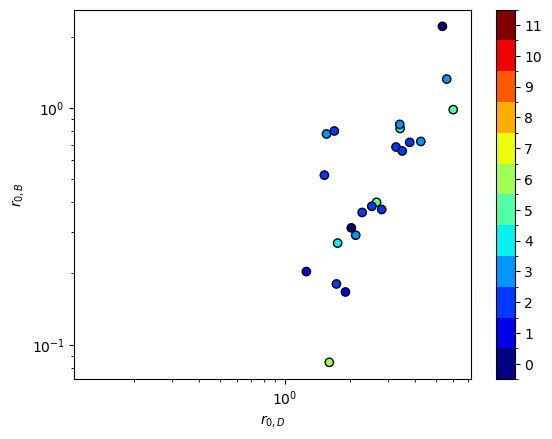

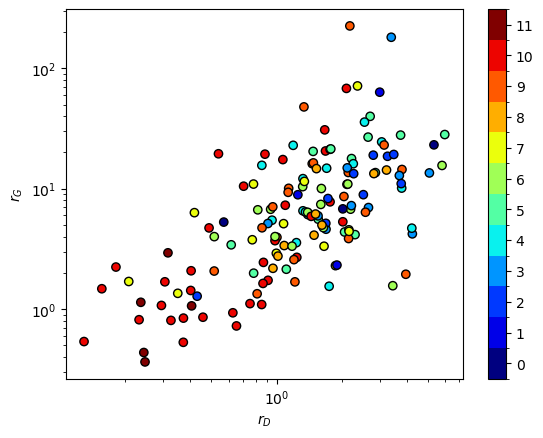

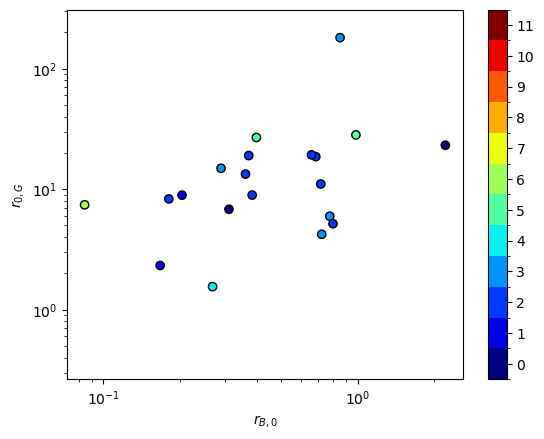

In [11]:
# figure settings for colormap
cmap = plt.cm.jet
norm = colors.BoundaryNorm(np.arange(-0.5, 12, 1), cmap.N)
# extract Hubble types
hType_list = [t["T"] for t in table]

# Compare Disk and Bulge (if present), scattered plot
plt.figure()
plt.scatter(densParam[:,0],densParam[:,2],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$r_{{0,D}}$")
plt.ylabel(f"$r_{{0,B}}$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,0],densParam[:,2])
print(f"rD-rB. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.4f}")

# Compare Disk and Gas, scattered plot
plt.figure()
plt.scatter(densParam[:,0],densParam[:,4],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$r_{{D}}$")
plt.ylabel(f"$r_{{G}}$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,0],densParam[:,4])
print(f"rD-rG. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.2e}")

# Compare Bulge (if present) and Gas, scattered plot
plt.figure()
plt.scatter(densParam[:,2],densParam[:,4],c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"$r_{{B,0}}$")
plt.ylabel(f"$r_{{0,G}}$")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,2],densParam[:,4])
print(f"rB-rG. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.4f}")

# Compare with tabulated SPARC data
---

*Test:* Compare effective estimates and SPARC data for: total luminosity, disk radius and total hydrogen mass. Spearman correlation Test is performed.
- effective total luminosity: $L_{Tot}= 4 \pi \int_0^\infty (\rho_{Disk}(s)+\rho_{Bulge}(s)+\rho_{Gas}(s) ) s^2 ds$
- effective disk radius: $r_0$
- effective total hydrogen mass: $M_{H} = 4 \pi \int_0^\infty \rho_{Gas}(s) s^2 ds$

*Result:* SPARC and effective quantities are not strongly correlated for total luminosity and total hydrogen mass. For the disk radius, they are related (approximately proportional, with the effective radius underestimating the SPARC radius)

Total luminosity. Spearman coeff (0 for uncorr, +-1 for corr): 0.8445,	pvalue: 8.78e-49
Disk radius. Spearman coeff (0 for uncorr, +-1 for corr): 0.9069,	pvalue: 7.39e-67
Total Hydrogen Mass. Spearman coeff (0 for uncorr, +-1 for corr): 0.4674,	pvalue: 6.95e-11


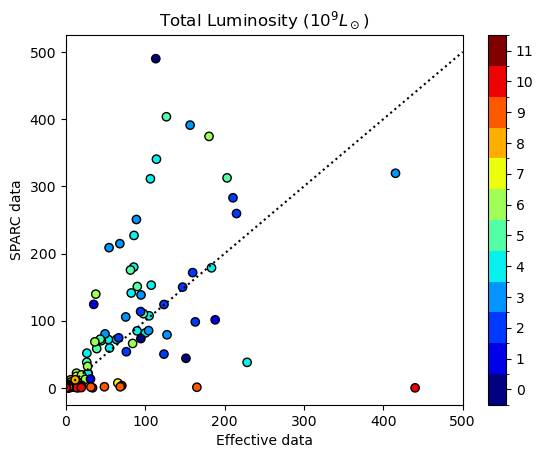

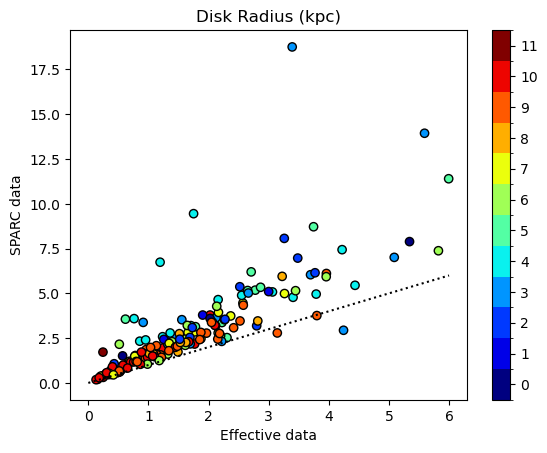

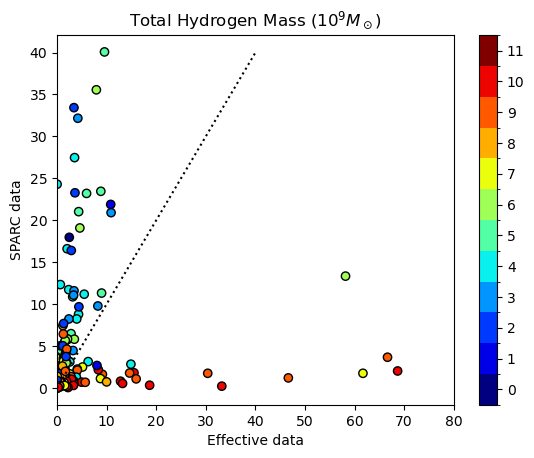

In [15]:
# Compute effective quantities
densTotParam = np.zeros((len(data_list),4))
for i in range(len(data_list)):
    lumDisk = 8*np.pi*densParam[i,1]*densParam[i,0]**2/1000
    lumBulge = 8*np.pi*densParam[i,3]*densParam[i,2]**2/1000
    lumGas = 8*np.pi*densParam[i,5]*densParam[i,4]**2/1000
    lumTot = lumDisk + lumBulge + lumGas
    densTotParam[i,:]=np.array([lumDisk,lumBulge,lumGas,lumTot])
    # print(f"Lum Disk: {lumDisk:.4f}\tLum Bulge: {lumBulge:.4f}\tLum Gas: {lumGas:.4f}\tLum tot: {lumTot:.4f}")

# figure settings for colormap
cmap = plt.cm.jet
norm = colors.BoundaryNorm(np.arange(-0.5, 12, 1), cmap.N)
# extract Hubble types
hType_list = [t["T"] for t in table]

# Get SPARC total luminosity
sparcData = [t["L[3.6]"] for t in table]
# scattered plot for total luminosity
plt.figure()
plt.scatter(densTotParam[:,3],sparcData,c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.plot([0,500],[0,500],':',color='black')
plt.xlabel(f"Effective data")
plt.ylabel("SPARC data")
plt.xlim([0,500])
plt.title(f"Total Luminosity ($10^9 L_\odot$)")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densTotParam[:,3],sparcData)
print(f"Total luminosity. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.2e}")

# Get SPARC disk radius
sparcData = [t["Rdisk"] for t in table]
# scattered plot for  disk radius
plt.figure()
plt.scatter(densParam[:,0],sparcData,c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.plot([0,6],[0,6],':',color='black')
plt.xlabel(f"Effective data")
plt.ylabel("SPARC data")
plt.title("Disk Radius (kpc)")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densParam[:,0],sparcData)
print(f"Disk radius. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.2e}")

# Get SPARC hydrogen mass
sparcData = [t["MHI"] for t in table]
# scattered plot for hydrogen mass
plt.figure()
plt.scatter(densTotParam[:,2],sparcData,c=hType_list, cmap=cmap, norm=norm, ec='k')
plt.plot([0,40],[0,40],':',color='black')
plt.xlabel(f"Effective data")
plt.ylabel("SPARC data")
plt.xlim([0,80])
plt.title("Total Hydrogen Mass ($10^9 M_\odot$)")
plt.colorbar(ticks=np.linspace(0, 11, 12))
# Spearman test for correlation
res = stats.spearmanr(densTotParam[:,2],sparcData)
print(f"Total Hydrogen Mass. Spearman coeff (0 for uncorr, +-1 for corr): {res.statistic:.4f},\tpvalue: {res.pvalue:.2e}")

